# Evolving Hunting Interferring Predator Prey Model
Extension fo the Hunting Interferring Predator Prey model with predators radius mutating. 

In [1]:
# import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
from multiprocessing import Pool
from tqdm import tqdm
import warnings
import os

# import datatime to set threads to 1
# allows for better multiprocessing
import datatable as dt
dt.options.nthreads = 1

# set nice plotting style
plt.style.use('bmh')

# IEBM modules
# point path to IEBM files
import sys
sys.path.append('../../')
# model population in 2-dimensions
from iebm.populations.population2D import Population2D
# import Trait classes to set up Events
from iebm.traits.static_trait import StaticTrait
from iebm.traits.linked_trait import LinkedTrait
from iebm.traits.mutable_trait import MutableTrait
# import BirthEvent for the prey
from iebm.events.birth import BirthEvent
# import DeathEvent for the predator
from iebm.events.death import DeathEvent
# movement is simulated by time to boundary (wall) events
from iebm.events.wall import WallEvent
# import 2D interaction for 2D populations
from iebm.events.interact2d import Interact2DEvent
# import class to simulate model
from iebm.simulation import Simulation
# event that pauses an individual for an alloted time
from iebm.events.pause import Pause2DEvent
# load rotate module for predators to hunt
from iebm.events.rotate import RotateEvent

## Parameters
Set parameters that are used in both the ODE and IEBM. Values selected to have small populations for faster simulations.

In [2]:
r = 0.001 # prey growth rate
a = 1 # predator attack rate
c = 1 # predator conversion efficiency
d = 0.001 # predator death rate
# size of environment
xdim = 500
ydim = 500
A = xdim * ydim
init_prey = 100 # starting prey population size
init_pred = 100 # starting predator population size
h = 75
# set the simulation time to certain number of cycles

time = 250000

# for the IEBM, individuals need explicit size
prey_radius = 1.0
pred_radius = 1.0

# metabolic constant to change death rate according to radius
bmet = d / (pred_radius**(-1/4))

In [3]:
# The predator radius starts at pred_radius and can lower to min_radius based on a mutation rate and mutation step
def ehirm_setup(k, stoppage, hunt_radius_factor, hunt_rate_factor, min_radius, mut_rate, mut_step):

    prey = Population2D(name='prey', init_size=init_prey, xdim=xdim, ydim=ydim, implicit_capacity=k)
    pred = Population2D(name='pred', init_size=init_pred, xdim=xdim, ydim=ydim)

    vel = a / (2 * (prey_radius + pred_radius))

    trait_prey = [(StaticTrait, {'name' : 'birth_rate', 
                                 'value' : r}), 
                  (StaticTrait, {'name' : 'radius', 
                                 'value' : prey_radius}),
                  (LinkedTrait, {'name' : 'predation_radius', 
                                 'link_trait' : 'radius', 
                                 'link_func' : lambda x : x})]

    event_prey = [(BirthEvent, {'name' : 'birth' , 
                                'is_primary' : True,
                                'current_time' : 0}), 
                  (DeathEvent, {'name' : 'death', 
                                'is_primary' : False, 
                                'current_time' : 0})]

    trait_pred = [(MutableTrait, {'name' : 'radius', 
                                  'track' : True,
                                  'value' : pred_radius, 
                                  'min_value' : min_radius, 
                                  'mutate_rate' : mut_rate, 
                                  'mutate_step' : mut_step}), 
                  (LinkedTrait, {'name' : 'predation_radius', 
                                 'link_trait' : 'radius', 
                                 'link_func' : lambda x: x}),
                  (LinkedTrait, {'name' : 'interfer_radius',
                                 'link_trait' : 'radius', 
                                 'link_func' : lambda x: x}),
                  (LinkedTrait, {'name' : 'velocity', 
                                 'link_trait' : 'radius', 
                                 'link_func' : lambda x :  a / (2 * (prey_radius + x))}),
                  (LinkedTrait, {'name' : 'death_rate', 
                                 'link_trait' : 'radius', 
                                 'link_func' : lambda x : bmet * x ** (-1/4)}),
                  (StaticTrait, {'name' : 'handling', 
                                 'value' : h}),                   
                  (StaticTrait, {'name' : 'stoppage', 
                                 'value' : stoppage}), 
                  (LinkedTrait, {'name' : 'hunt_radius',
                                 'link_trait' : 'radius', 
                                 'link_func' : lambda x: x * hunt_radius_factor}), 
                  (LinkedTrait, {'name' : 'hunt_rate', 
                                 'link_trait' : 'death_rate',
                                 'link_func' : lambda x : x * hunt_rate_factor})]
    
    event_pred = [(DeathEvent, {'name' : 'death',
                                'is_primary' : True,
                                'current_time' : 0}), 
                  (WallEvent, {'name' : 'wall', 
                               'is_primary' : True, 
                               'current_time' : 0, 
                               'bounce' : 'random'}), 
                  (Interact2DEvent, {'name' : 'predation',
                                     'is_primary' : True,
                                     'tirgger_set_next' : True,
                                     'current_time'  : 0, 
                                     'other' : prey}), 
                  (Pause2DEvent, {'name' : 'handling',
                                  'ignore_list' : ['death'],
                                  'is_primary' : False}),
                  (Interact2DEvent, {'name' : 'interfer',
                                     'is_primary' : True,
                                     'tirgger_set_next' : True,
                                     'current_time'  : 0}), 
                  (Pause2DEvent, {'name' : 'stoppage',
                                  'ignore_list' : ['death'],
                                  'is_primary' : False}),
                  (BirthEvent, {'name' : 'birth', 
                                'is_primary' : False, 
                                'current_time' : 0}), 
                  (RotateEvent, {'name' : 'hunt', 
                                 'is_primary' : True,
                                 'attract_population' : prey,
                                 'current_time' : 0})]   
    
    return prey, pred, trait_prey, trait_pred, event_prey, event_pred

In [4]:
# function to run am intereferring Rosenzweig-MacArthur model from the returned value of rm_setup.
def ehirm_model(prey, pred, trait_prey, trait_pred, event_prey, event_pred, progress_bar=True):
    
    prey.add_traits(trait_prey)
    prey.add_events(event_prey)
    pred.add_traits(trait_pred)
    pred.add_events(event_pred)    
    
    # list what events to stop at pause
    # predation
    set_list = [c for c in pred.event_list if c not in pred.event_dict['handling'].ignore_list]
    pred.event_dict['handling'].set_list = set_list
    # interference
    set_list = [c for c in pred.event_list if c not in pred.event_dict['stoppage'].ignore_list]
    pred.event_dict['stoppage'].set_list = set_list

    # add event triggers to finish setting up system
    # when new prey is born, check and create new predation collisions
    # and add new offspring to hunt rtree
    def prey_birth(params):
        new_events = []
        new_events += pred.event_dict['predation'].set_other_next(params)
        new_events += pred.event_dict['hunt'].add_attracted(params)
        return new_events
    prey.event_dict['birth'].triggers = prey_birth

    # when prey dies, remove from hunt indes
    prey.event_dict['death'].triggers = pred.event_dict['hunt'].remove_attracted

    # set the trigger for a predation interaction event
    # a few things occur at a predation event, so we need a function
    def predation_trigger(params):
        events = []
        other_params = params.copy()
        other_params['actor_id'] = other_params['extra']
        # the prey is removed
        events += prey.event_dict['death'].handle(other_params)
        # the predator pauses to handle 
        events += pred.event_dict['handling'].set_next(params)
        return events
    pred.event_dict['predation'].triggers = predation_trigger

    # after handling, predator can give birth and get new settings
    def handle_trigger(params):
        events = []
        # now that individual is active:
        # set new wall times
        pred.event_dict['wall'].set_next(params)
        # set next predation times
        pred.event_dict['predation'].set_next(params)
        # set next interfer times
        pred.event_dict['interfer'].set_next(params)
        # possibly create offspring after handling
        events += pred.event_dict['birth'].handle(params)
        # get individual's next evet
        events += [pred.get_next_event(params['actor_id'])]
        return events
    pred.event_dict['handling'].triggers = handle_trigger

    # set triggers when individual predators collide
    def stoppage_trigger(params):
        events = []
        # stop other
        other_params = params.copy()
        other_params['actor_id'] = other_params['extra']
        events += pred.event_dict['stoppage'].set_next(other_params)
        # stop this individual
        events += pred.event_dict['stoppage'].set_next(params)
        return events
    pred.event_dict['interfer'].triggers = stoppage_trigger

    # after stopping, predators can resume activity
    def resume_trigger(params):
        events = []
        # set new wall times
        pred.event_dict['wall'].set_next(params)
        # set next predation times
        pred.event_dict['predation'].set_next(params)
        # set next interfer times
        pred.event_dict['interfer'].set_next(params)
        # get individuals next event
        events += [pred.get_next_event(params['actor_id'])]
        return events
    pred.event_dict['stoppage'].triggers = resume_trigger

    # set triggers to calculate new interactions after wall collision
    def new_interactions(params):
        new_events = []
        new_events += pred.event_dict['predation'].set_next(params)
        new_events += pred.event_dict['interfer'].set_next(params)
        return new_events
    pred.event_dict['wall'].triggers = new_interactions

    # hunt trigger, change direction after angle change
    # exact same as resume
    pred.event_dict['hunt'].triggers = resume_trigger
    
    # add the pops to a dictionary 
    pop_dict = {str(prey) : prey, 
                str(pred) : pred}

    # create the simulation with the population dictionary
    sim = Simulation(pop_dict)
    
    # run simulation
    sim.run(time, progress_bar=progress_bar)

    # return simulation resuls
    res = sim.get_results()
    
    return res

In [5]:
# function to run in parallel
def run_parallel(k, s, hrad, hrat, min_radius, mut_rate, mut_step):
    prey, pred, trait_prey, trait_pred, event_prey, event_pred = ehirm_setup(k, s, hrad, hrat, min_radius, mut_rate, mut_step)
    res = ehirm_model(prey, pred, trait_prey, trait_pred, event_prey, event_pred, progress_bar=False)  
    return [k, s, hrad, hrat, min_radius, mut_rate, mut_step, res]

In [6]:
%%time
# run IEBM a few times on select carrying capacties, stoppage, and hunt_factors

ks = [2000]
ss = [5]
hrads = [10]
hrats = [100]
min_radii = [0.2]
mut_rates = [0.01]
mut_steps = [0.01]
runs = 1 #99

params = [(k, s, hrad, hrat, mri, mrt, ms) 
          for k in ks 
          for s in ss 
          for hrad in hrads 
          for hrat in hrats 
          for mri in min_radii
          for mrt in mut_rates
          for ms  in mut_steps
          for _ in range(runs)]

"""
pbar = tqdm(total=len(params))

res = []
def update(a):
    res.append(a)
    pbar.update()

pool = Pool()

for (k, s, hrad, hrat, mri, mrt, ms) in params:
    pool.apply_async(run_parallel, (k, s, hrad, hrat, mri, mrt, ms), 
                     callback=update)

pool.close()
pool.join()
pbar.close()
"""

prey, pred, trait_prey, trait_pred, event_prey, event_pred = ehirm_setup(*params[0])
res = ehirm_model(prey, pred, trait_prey, trait_pred, event_prey, event_pred, progress_bar=True) 


100%|█████████▉| 249982.7503/250000 [48:44<00:00, 164.23it/s] /home/jordan/miniconda3/envs/ebm/lib/python3.7/site-packages/tqdm/std.py:521: TqdmWarning: clamping frac to range [0, 1]
  colour=colour)
100%|██████████| 250000.2512/250000 [48:44<00:00, 85.47it/s] 

CPU times: user 48min 42s, sys: 10.8 s, total: 48min 53s
Wall time: 48min 44s


In [7]:
%%time

trait_df = []
for time, (vals, cnts) in zip(res['time'], res['trait'][('pred', 'radius')]):
    cnts_sum = cnts.sum()
    for i in range(len(vals)):
        trait_df.append([time, vals[i], cnts[i]/cnts_sum])
trait_df = pd.DataFrame(trait_df, columns=['time', 'val', 'freq'])

CPU times: user 27.7 s, sys: 877 ms, total: 28.6 s
Wall time: 28.6 s


In [8]:
time_grp = 10
trait_df['time_grp'] = (trait_df.time // time_grp).astype(np.int64)
trait_grp = trait_df.groupby(['time_grp', 'val']).freq.mean().reset_index()

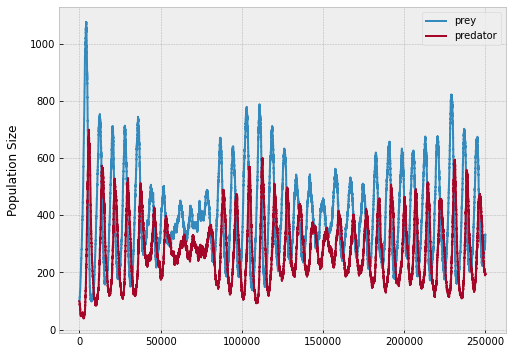

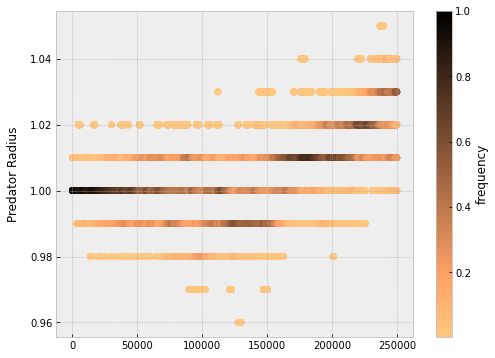

In [22]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(res['time'], res['size']['prey'], label='prey')
ax.plot(res['time'], res['size']['pred'], label='predator')
ax.legend()
ax.set_ylabel('Population Size', labelpad=10)
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
scat = ax.scatter(trait_grp.time_grp*time_grp, trait_grp.val, c=trait_grp.freq, cmap=plt.cm.copper_r)
cb = plt.colorbar(scat, ax=ax)
cb.set_label('frequency')
ax.set_ylabel('Predator Radius', labelpad=10)
#ax[1].set_xlabel('Tim, labelpad=10)


plt.show()